In [5]:
import pandas as pd
import json
from transformers import RobertaTokenizer
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

In [6]:
class HEDataset(Dataset):
    def __init__(self, path, split):
        self.num_classes = 1
        self.split = split
        self.tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
        self.data = self.load_data(path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def load_data(self, path):
        data = []

        df = pd.read_pickle(path)
        df = df[df['split'] == self.split]
        # df = df[df['label'].apply(lambda x: len(x) > 0)]
        df['label'] = df['label'].apply(lambda x: [0] if 1 in x else [])

        input_ids, att_mask = self.tokenizer(df['text'].to_list(), padding='max_length', max_length=512, truncation=True, return_tensors='pt').values()

        label_freqs = df['label'].explode().value_counts().sort_index()
        label_freqs /= label_freqs.sum()
        self.wts = torch.FloatTensor(label_freqs.to_list())

        for i in range(len(df)):
            target = torch.zeros(self.num_classes)
            for l in df['label'].iloc[i]:
                target[l] = 1
            data.append({
                'input_ids': input_ids[i],
                'attention_mask': att_mask[i],
                'target': target
            })

        return data

In [11]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, get_linear_schedule_with_warmup
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report
from collections import defaultdict

class Agent:
    def __init__(self):

        self.train_dataset = HEDataset('multi_combined_data.pkl', split='train')
        self.val_dataset = HEDataset('multi_combined_data.pkl', split='val')
        self.train_loader = DataLoader(self.train_dataset, batch_size=1, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=1, shuffle=False)

        self.device = 'cuda'
        self.encoder = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=self.train_dataset.num_classes).to(self.device)
        self.num_epochs = 200

        # freeze all except last 3 layers
        for param in self.encoder.roberta.parameters():
            param.requires_grad = False
        for param in self.encoder.roberta.encoder.layer[-3:].parameters():
            param.requires_grad = True
        # for param in self.encoder.roberta.pooler.parameters():
        #     param.requires_grad = True

        self.tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
        self.optimizer = torch.optim.AdamW(self.encoder.parameters(), lr=1e-6, weight_decay=5e-1)
        self.train_metrics = defaultdict(list)
        self.val_metrics = defaultdict(list)

        num_training_steps = len(self.train_dataset) * self.num_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=num_training_steps * 0.9,
            num_training_steps=num_training_steps,
        )

    def load_model(self, path):
        self.encoder.load_state_dict(torch.load(path))

    def train(self):
        for self.epoch in range(self.num_epochs):
            self.train_one_epoch()

            if self.epoch % 1 == 0:
                self.validate()

                if max(self.val_metrics['loss']) == self.val_metrics['loss'][-1]:
                    print('Saving best model...')
                    torch.save(self.encoder.state_dict(), 'best_model.pt')

    def train_one_epoch(self):
        self.encoder.train()

        all_preds = []
        all_targets = []

        losses = []
        accs = []
        tqdm_batch = tqdm(self.train_loader, total=len(self.train_loader), desc=f'Train [Epoch {self.epoch}]')
        for batch in tqdm_batch:
            self.optimizer.zero_grad()

            loss, acc, preds = self.forward(batch)
            loss.backward()
            
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(batch['target'].cpu().numpy())

            self.optimizer.step()
            self.scheduler.step()

            losses.append(loss.item())
            accs.append(acc)
            tqdm_batch.set_postfix({'loss': np.mean(losses), 'acc': np.mean(accs)})
        self.train_metrics['loss'].append(np.mean(losses))
        self.train_metrics['acc'].append(np.mean(accs))
        self.train_metrics['report_dict'].append(classification_report(np.concatenate(all_targets), np.concatenate(all_preds), zero_division=0, output_dict=True))
        self.train_metrics['report'].append(classification_report(np.concatenate(all_targets), np.concatenate(all_preds), zero_division=np.nan))
        self.train_metrics['lr'].append(self.optimizer.param_groups[0]['lr'])

    @torch.no_grad()
    def validate(self):
        self.encoder.eval()

        all_preds = []
        all_targets = []

        losses = []
        accs = []
        tqdm_batch = tqdm(self.val_loader, total=len(self.val_loader), desc='Val')
        for batch in tqdm_batch:

            loss, acc, preds = self.forward(batch)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(batch['target'].cpu().numpy())
            losses.append(loss.item())
            accs.append(acc)
            tqdm_batch.set_postfix({'loss': np.mean(losses), 'acc': np.mean(accs)})
        self.val_metrics['loss'].append(np.mean(losses))
        self.val_metrics['acc'].append(np.mean(accs))
        self.val_metrics['report_dict'].append(classification_report(np.concatenate(all_targets), np.concatenate(all_preds), zero_division=0, output_dict=True))
        self.val_metrics['report'].append(classification_report(np.concatenate(all_targets), np.concatenate(all_preds), zero_division=np.nan))

    def forward(self, batch):
        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)
        target = batch['target'].to(self.device)
        outputs = self.encoder(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = torch.sigmoid(logits).round()
        acc = (preds == target).sum().item() / target.numel()
        loss = self.compute_loss_multilabel(logits, target)
        return loss, acc, preds

    def compute_loss_multilabel(self, logits, target):
        # target is onehot
        return F.binary_cross_entropy_with_logits(torch.sigmoid(logits), target, weight=self.train_dataset.wts.to(self.device))

    def dump_val_preds(self):
        np.set_printoptions(precision=4, suppress=True)
        torch.set_printoptions(precision=4, sci_mode=False)

        self.encoder.eval()
        preds = []
        targets = []
        with torch.no_grad():
            for batch in self.val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                target = batch['target'].to(self.device)

                outputs = self.encoder(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds.append(torch.sigmoid(logits).round().cpu().numpy())
                targets.append(target.cpu().numpy())
        for p, t in zip(preds, targets):
            print(p.squeeze(0), t.squeeze(0))


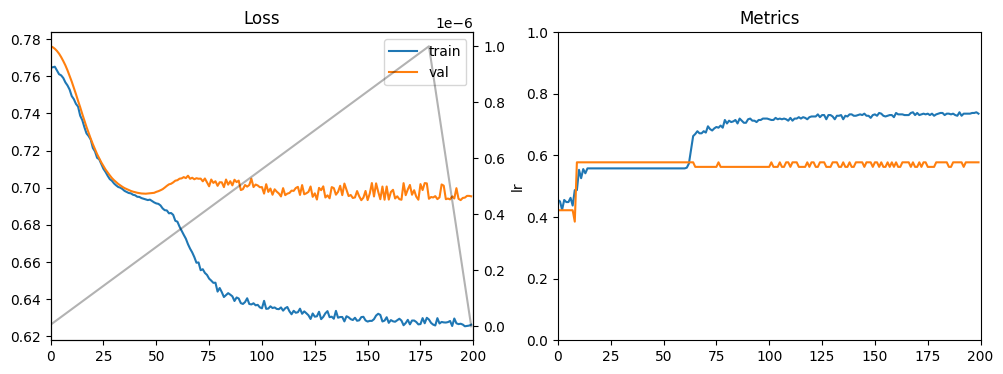

Train report                                                                                                                                                                                                                                                                                                                            Val report
              precision    recall  f1-score   support               precision    recall  f1-score   support
 
         0.0       0.68      1.00      0.81       245          0.0       0.58      1.00      0.73        78
         1.0       0.99      0.41      0.58       194          1.0        nan      0.00      0.00        57
 
    accuracy                           0.74       439     accuracy                           0.58       135
   macro avg       0.83      0.70      0.69       439    macro avg       0.58      0.50      0.37       135
weighted avg       0.82      0.74      0.71       439 weighted avg       0.58      0.58      0.42       135
 



In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

torch.random.manual_seed(42)
np.random.seed(42)

a = Agent()

for a.epoch in range(a.num_epochs):
    a.train_one_epoch()
    a.validate()
    clear_output()

    ax, fig = plt.subplots(1, 2, figsize=(12, 4))
    ax2 = fig[0].twinx()
    ax2.plot(a.train_metrics['lr'], color='black', alpha=0.3)
    ax2.set_ylabel('lr')
    fig[0].set_xlim(0, a.num_epochs)
    fig[0].plot(a.train_metrics['loss'], label='train')
    fig[0].plot(a.val_metrics['loss'], label='val')
    fig[0].set_title('Loss')
    fig[0].legend()

    fig[1].set_xlim(0, a.num_epochs)
    fig[1].set_ylim(0, 1)
    # fig[1].plot(list(map(lambda x: x['0']['f1-score'], a.train_metrics['report_dict'])), c='lightred')
    # fig[1].plot(list(map(lambda x: x['1']['f1-score'], a.train_metrics['report_dict'])), c='red')
    # fig[1].plot(list(map(lambda x: x['2']['f1-score'], a.train_metrics['report_dict'])), c='darkred')
    # fig[1].plot(list(map(lambda x: x['0']['f1-score'], a.train_metrics['report_dict'])), c='lightblue')
    # fig[1].plot(list(map(lambda x: x['1']['f1-score'], a.train_metrics['report_dict'])), c='blue')
    # fig[1].plot(list(map(lambda x: x['2']['f1-score'], a.train_metrics['report_dict'])), c='darkblue')
    # fig[1].plot(list(map(lambda x: x['0']['precision'], a.train_metrics['report_dict'])), c='r')
    # fig[1].plot(list(map(lambda x: x['0']['recall'], a.train_metrics['report_dict'])), c='darkred')
    # fig[1].plot(list(map(lambda x: x['1']['precision'], a.train_metrics['report_dict'])), c='g')
    # fig[1].plot(list(map(lambda x: x['1']['recall'], a.train_metrics['report_dict'])), c='darkgreen')
    # fig[1].plot(list(map(lambda x: x['2']['precision'], a.train_metrics['report_dict'])), c='b')
    # fig[1].plot(list(map(lambda x: x['2']['recall'], a.train_metrics['report_dict'])), c='darkblue')
    # fig[1].plot(list(map(lambda x: x['0']['precision'], a.val_metrics['report_dict'])), c='r', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['0']['recall'], a.val_metrics['report_dict'])), c='darkred', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['1']['precision'], a.val_metrics['report_dict'])), c='g', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['1']['recall'], a.val_metrics['report_dict'])), c='darkgreen', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['2']['precision'], a.val_metrics['report_dict'])), c='b', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['2']['recall'], a.val_metrics['report_dict'])), c='darkblue', linestyle='--')
    fig[1].plot(a.train_metrics['acc'], label='train')
    fig[1].plot(a.val_metrics['acc'], label='val')
    fig[1].set_title('Metrics')
    # lines = [Line2D([0], [0], color='black'), Line2D([0], [0], color='black', linestyle='--'),
    #         Line2D([0], [0], color='red'), Line2D([0], [0], color='darkred')]
    # fig[1].legend(lines, ['Train', 'Val', 'Precision', 'Recall'])
    plt.show()
 
    print(f"Train report { ' ' * (len(a.train_metrics['report'][-1]) - 12) } Val report")
    for line in zip(a.train_metrics['report'][-1].split('\n'), a.val_metrics['report'][-1].split('\n')):
        print(line[0], line[1])
    print()


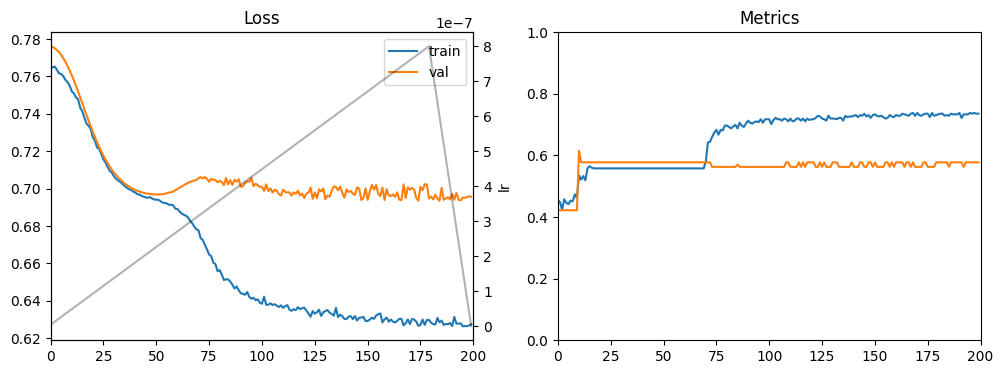

Train report                                                                                                                                                                                                                                                                                                                            Val report
              precision    recall  f1-score   support               precision    recall  f1-score   support
 
         0.0       0.68      1.00      0.81       245          0.0       0.58      1.00      0.73        78
         1.0       0.99      0.41      0.58       194          1.0        nan      0.00      0.00        57
 
    accuracy                           0.74       439     accuracy                           0.58       135
   macro avg       0.83      0.70      0.69       439    macro avg       0.58      0.50      0.37       135
weighted avg       0.82      0.74      0.71       439 weighted avg       0.58      0.58      0.42       135
 



In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

torch.random.manual_seed(42)
np.random.seed(42)

a = Agent()

for a.epoch in range(a.num_epochs):
    a.train_one_epoch()
    a.validate()
    clear_output()

    ax, fig = plt.subplots(1, 2, figsize=(12, 4))
    ax2 = fig[0].twinx()
    ax2.plot(a.train_metrics['lr'], color='black', alpha=0.3)
    ax2.set_ylabel('lr')
    fig[0].set_xlim(0, a.num_epochs)
    fig[0].plot(a.train_metrics['loss'], label='train')
    fig[0].plot(a.val_metrics['loss'], label='val')
    fig[0].set_title('Loss')
    fig[0].legend()

    fig[1].set_xlim(0, a.num_epochs)
    fig[1].set_ylim(0, 1)
    # fig[1].plot(list(map(lambda x: x['0']['f1-score'], a.train_metrics['report_dict'])), c='lightred')
    # fig[1].plot(list(map(lambda x: x['1']['f1-score'], a.train_metrics['report_dict'])), c='red')
    # fig[1].plot(list(map(lambda x: x['2']['f1-score'], a.train_metrics['report_dict'])), c='darkred')
    # fig[1].plot(list(map(lambda x: x['0']['f1-score'], a.train_metrics['report_dict'])), c='lightblue')
    # fig[1].plot(list(map(lambda x: x['1']['f1-score'], a.train_metrics['report_dict'])), c='blue')
    # fig[1].plot(list(map(lambda x: x['2']['f1-score'], a.train_metrics['report_dict'])), c='darkblue')
    # fig[1].plot(list(map(lambda x: x['0']['precision'], a.train_metrics['report_dict'])), c='r')
    # fig[1].plot(list(map(lambda x: x['0']['recall'], a.train_metrics['report_dict'])), c='darkred')
    # fig[1].plot(list(map(lambda x: x['1']['precision'], a.train_metrics['report_dict'])), c='g')
    # fig[1].plot(list(map(lambda x: x['1']['recall'], a.train_metrics['report_dict'])), c='darkgreen')
    # fig[1].plot(list(map(lambda x: x['2']['precision'], a.train_metrics['report_dict'])), c='b')
    # fig[1].plot(list(map(lambda x: x['2']['recall'], a.train_metrics['report_dict'])), c='darkblue')
    # fig[1].plot(list(map(lambda x: x['0']['precision'], a.val_metrics['report_dict'])), c='r', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['0']['recall'], a.val_metrics['report_dict'])), c='darkred', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['1']['precision'], a.val_metrics['report_dict'])), c='g', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['1']['recall'], a.val_metrics['report_dict'])), c='darkgreen', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['2']['precision'], a.val_metrics['report_dict'])), c='b', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['2']['recall'], a.val_metrics['report_dict'])), c='darkblue', linestyle='--')
    fig[1].plot(a.train_metrics['acc'], label='train')
    fig[1].plot(a.val_metrics['acc'], label='val')
    fig[1].set_title('Metrics')
    # lines = [Line2D([0], [0], color='black'), Line2D([0], [0], color='black', linestyle='--'),
    #         Line2D([0], [0], color='red'), Line2D([0], [0], color='darkred')]
    # fig[1].legend(lines, ['Train', 'Val', 'Precision', 'Recall'])
    plt.show()
 
    print(f"Train report { ' ' * (len(a.train_metrics['report'][-1]) - 12) } Val report")
    for line in zip(a.train_metrics['report'][-1].split('\n'), a.val_metrics['report'][-1].split('\n')):
        print(line[0], line[1])
    print()


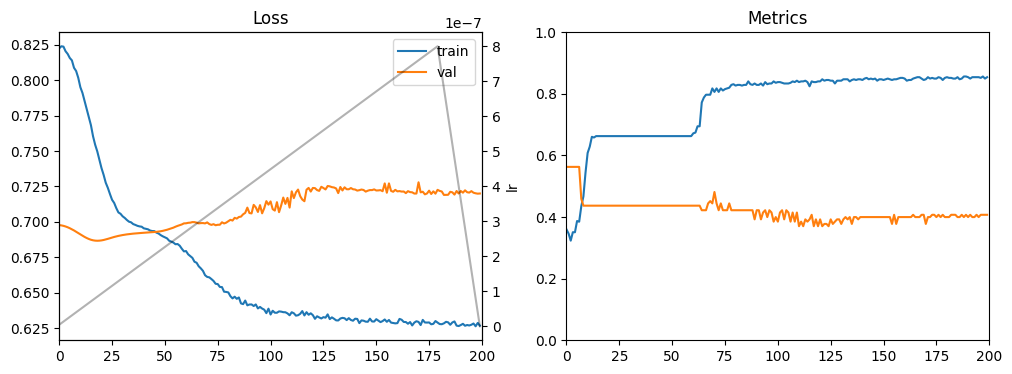

Train report                                                                                                                                                                                                                                                                                                                            Val report
              precision    recall  f1-score   support               precision    recall  f1-score   support
 
         0.0       0.84      0.96      0.90       291          0.0       0.41      0.86      0.56        59
         1.0       0.90      0.64      0.75       148          1.0       0.33      0.05      0.09        76
 
    accuracy                           0.85       439     accuracy                           0.41       135
   macro avg       0.87      0.80      0.82       439    macro avg       0.37      0.46      0.33       135
weighted avg       0.86      0.85      0.85       439 weighted avg       0.37      0.41      0.30       135
 



In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

torch.random.manual_seed(42)
np.random.seed(42)

a = Agent()

for a.epoch in range(a.num_epochs):
    a.train_one_epoch()
    a.validate()
    clear_output()

    ax, fig = plt.subplots(1, 2, figsize=(12, 4))
    ax2 = fig[0].twinx()
    ax2.plot(a.train_metrics['lr'], color='black', alpha=0.3)
    ax2.set_ylabel('lr')
    fig[0].set_xlim(0, a.num_epochs)
    fig[0].plot(a.train_metrics['loss'], label='train')
    fig[0].plot(a.val_metrics['loss'], label='val')
    fig[0].set_title('Loss')
    fig[0].legend()

    fig[1].set_xlim(0, a.num_epochs)
    fig[1].set_ylim(0, 1)
    # fig[1].plot(list(map(lambda x: x['0']['f1-score'], a.train_metrics['report_dict'])), c='lightred')
    # fig[1].plot(list(map(lambda x: x['1']['f1-score'], a.train_metrics['report_dict'])), c='red')
    # fig[1].plot(list(map(lambda x: x['2']['f1-score'], a.train_metrics['report_dict'])), c='darkred')
    # fig[1].plot(list(map(lambda x: x['0']['f1-score'], a.train_metrics['report_dict'])), c='lightblue')
    # fig[1].plot(list(map(lambda x: x['1']['f1-score'], a.train_metrics['report_dict'])), c='blue')
    # fig[1].plot(list(map(lambda x: x['2']['f1-score'], a.train_metrics['report_dict'])), c='darkblue')
    # fig[1].plot(list(map(lambda x: x['0']['precision'], a.train_metrics['report_dict'])), c='r')
    # fig[1].plot(list(map(lambda x: x['0']['recall'], a.train_metrics['report_dict'])), c='darkred')
    # fig[1].plot(list(map(lambda x: x['1']['precision'], a.train_metrics['report_dict'])), c='g')
    # fig[1].plot(list(map(lambda x: x['1']['recall'], a.train_metrics['report_dict'])), c='darkgreen')
    # fig[1].plot(list(map(lambda x: x['2']['precision'], a.train_metrics['report_dict'])), c='b')
    # fig[1].plot(list(map(lambda x: x['2']['recall'], a.train_metrics['report_dict'])), c='darkblue')
    # fig[1].plot(list(map(lambda x: x['0']['precision'], a.val_metrics['report_dict'])), c='r', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['0']['recall'], a.val_metrics['report_dict'])), c='darkred', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['1']['precision'], a.val_metrics['report_dict'])), c='g', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['1']['recall'], a.val_metrics['report_dict'])), c='darkgreen', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['2']['precision'], a.val_metrics['report_dict'])), c='b', linestyle='--')
    # fig[1].plot(list(map(lambda x: x['2']['recall'], a.val_metrics['report_dict'])), c='darkblue', linestyle='--')
    fig[1].plot(a.train_metrics['acc'], label='train')
    fig[1].plot(a.val_metrics['acc'], label='val')
    fig[1].set_title('Metrics')
    # lines = [Line2D([0], [0], color='black'), Line2D([0], [0], color='black', linestyle='--'),
    #         Line2D([0], [0], color='red'), Line2D([0], [0], color='darkred')]
    # fig[1].legend(lines, ['Train', 'Val', 'Precision', 'Recall'])
    plt.show()
 
    print(f"Train report { ' ' * (len(a.train_metrics['report'][-1]) - 12) } Val report")
    for line in zip(a.train_metrics['report'][-1].split('\n'), a.val_metrics['report'][-1].split('\n')):
        print(line[0], line[1])
    print()


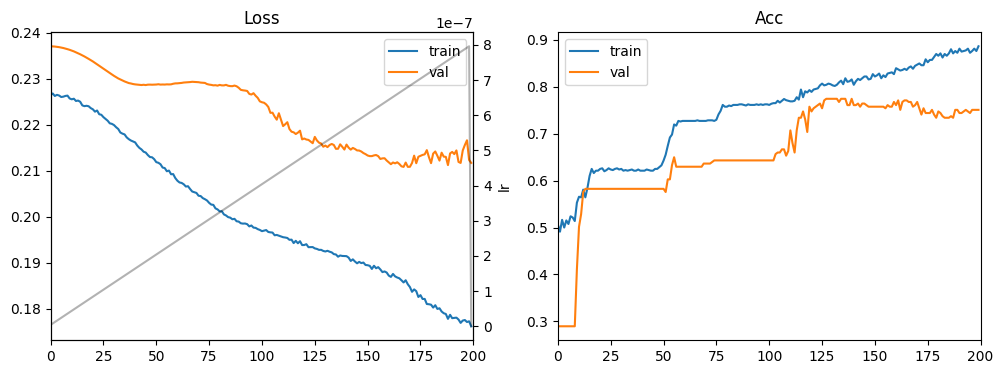

Train report                                                                                                                                                                                                                                                                                                                                                                                                                                        Val report
              precision    recall  f1-score   support               precision    recall  f1-score   support
 
           0       0.91      0.98      0.94       148            0       0.94      0.78      0.85        76
           1       0.92      0.94      0.93       194            1       0.59      0.75      0.66        57
           2       0.95      0.48      0.63        82            2       0.29      0.33      0.31         6
 
   micro avg       0.92      0.86      0.89       424    micro avg       0.73      0.75      0.74       139
   macro 

In [30]:
import matplotlib.pyplot as plt
a = Agent()

for a.epoch in range(a.num_epochs):
    a.train_one_epoch()
    a.validate()
    clear_output()

    ax, fig = plt.subplots(1, 2, figsize=(12, 4))
    ax2 = fig[0].twinx()
    ax2.plot(a.train_metrics['lr'], color='black', alpha=0.3)
    ax2.set_ylabel('lr')
    fig[0].set_xlim(0, a.num_epochs)
    fig[0].plot(a.train_metrics['loss'], label='train')
    fig[0].plot(a.val_metrics['loss'], label='val')
    fig[0].set_title('Loss')
    fig[0].legend()
    
    fig[1].set_xlim(0, a.num_epochs)
    fig[1].plot(a.train_metrics['acc'], label='train')
    fig[1].plot(a.val_metrics['acc'], label='val')
    fig[1].set_title('Acc')
    fig[1].legend()
    plt.show()

    print(f"Train report { ' ' * (len(a.train_metrics['report'][-1]) - 12) } Val report")
    for line in zip(a.train_metrics['report'][-1].split('\n'), a.val_metrics['report'][-1].split('\n')):
        print(line[0], line[1])
    print()
